In [1]:
import cv2
from pathlib import Path
from random import *
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.feature import hog
from imutils import face_utils
#import dlib
import os
import pickle
np.random.seed(1000)


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
frames = []
labels = []
for file in os.listdir('output/'):
    if file[-13:] == 'frames.pickle':
        with open('output/'+file, 'rb') as f:
            frames.append(pickle.load(f))
    elif file[-13:] == 'labels.pickle':
        with open('output/'+file, 'rb') as f:
            labels.append(pickle.load(f))

In [4]:
print(len(frames), len(labels))

8231 8231


In [5]:
from sklearn.model_selection import train_test_split
train_clips, test_clips, train_clips_labels, test_clips_labels = \
    train_test_split(frames, labels, test_size=0.2, random_state=42)

In [6]:
train_images, test_images, train_labels, test_labels = [], [], [], []

for clip, label in zip(train_clips, train_clips_labels):
    try:
        train_images, train_labels = train_images + clip, train_labels + [label[0]] * len(clip)
    except Exception as e:
        continue

for clip, label in zip(test_clips, test_clips_labels):
    try:
        test_images, test_labels = test_images + clip, test_labels + [label[0]] * len(clip)
    except Exception as e:
        continue
    
print(len(train_images), len(train_labels), len(test_images), len(test_labels))

1974773 1974773 493987 493987


In [7]:
train_images, test_images, train_labels, test_labels = np.asarray(train_images), np.asarray(test_images), np.asarray(train_labels), np.asarray(test_labels)

In [8]:
test_images, test_labels =np.asarray(test_images), np.asarray(test_labels)

In [9]:
test_images = np.expand_dims(test_images, axis=3)
train_images = np.expand_dims(train_images, axis=3)

In [43]:
import tensorflow.keras.layers as kl
import tensorflow.keras.losses
from tensorflow.keras.applications.resnet50 import ResNet50

In [78]:
def network():
    model = tf.keras.Sequential()
    model.add(kl.InputLayer(input_shape=(48, 48, 1)))
    # First conv block
    model.add(kl.Conv2D(filters = 96, kernel_size=7, padding='same', strides=2))
    model.add(tf.keras.layers.ReLU())
    model.add(kl.MaxPooling2D(pool_size=(3, 3)))
    # Second conv block
    model.add(kl.Conv2D(filters = 144, kernel_size=5, padding='same', strides=1))
    model.add(tf.keras.layers.ReLU())
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.5))
    # Third-Fourth-Fifth conv block
    for i in range(3):
        model.add(kl.Conv2D(filters = 144, kernel_size=3, padding='same', strides=1))
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.Dropout(0.5))
    model.add(kl.MaxPooling2D(pool_size=(3, 3)))
    # Flatten
    model.add(kl.Flatten())
    # First FC 
    model.add(kl.Dense(4048))
    # Second Fc
    model.add(kl.Dense(4048))
    # Third FC
    model.add(kl.Dense(18, activation='sigmoid'))
    
    return model

In [79]:
model = network()
InitialLearnRate = 0.03
MaxEpochs = 30
MiniBatchSize = 32
opt = tf.keras.optimizers.SGD(lr=InitialLearnRate, decay=InitialLearnRate / MaxEpochs)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])


In [83]:
model.fit(train_images, train_labels, epochs=2, batch_size=50)

Train on 1974773 samples
Epoch 1/2
1974773/1974773 [==============================] - 271s 137us/sample - loss: 0.3220 - accuracy: 0.8692
Epoch 2/2
1974773/1974773 [==============================] - 267s 135us/sample - loss: 0.3190 - accuracy: 0.8709


In [84]:
test_loss, test_acc = model.evaluate(test_images,  test_labels)

493987/493987 [==============================] - 34s 68us/sample - loss: 0.3878 - accuracy: 0.8768


(1, 48, 48, 1)
[0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.2405851  0.27745926 0.62066346 0.38186827 0.21612109 0.4847214
  0.05815895 0.128251   0.09586369 0.5540133  0.14637493 0.22996923
  0.1706232  0.2421216  0.27198803 0.24291526 0.02562252 0.31332058]]


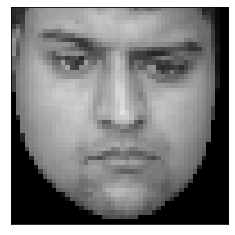

In [85]:
def removePlotterAxes():
    plt.figure()
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pass
def plotImg(img):
    removePlotterAxes()
    plt.imshow(img)
    pass

plotImg(cv2.cvtColor(test_images[1500], cv2.COLOR_BGR2RGB))
prd = np.expand_dims(test_images[1500], axis=0)
print(prd.shape)
print(test_labels[1500])
print(np.rint(model.predict(prd)))
print(model.predict(prd))

In [87]:
model.save('AUs.h5')